# Faire un métamodèle de krigeage


## Références

http://openturns.github.io/openturns/master/theory/meta_modeling/kriging.html

http://openturns.github.io/openturns/master/examples/meta_modeling/kriging.html

[Formation ITECH, Introduction aux métamodèles (polynômes de chaos et krigeage) (ARN4889)
14 septembre 2016, Copyright EDF 2015 - Géraud Blatman (EDF R&D/MMC) & Loïc Le Gratiet (EDF R&D/MRI)][1]

[François Bachoc. Introduction to Gaussian-process based Kriging models for metamodeling and validation of computer codes. Seminar of the LRC MANON, INSTN Saclay, March 2014.][2]

[C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006,
ISBN 026218253X. 2006 Massachusetts Institute of Technology.][3]

[François Bachoc. Parametric estimation of covariance function in Gaussian-process based Kriging models. Application to uncertainty quantification for computer experiments. Thèse de l'université Paris-Diderot, 2013.][4]

[Loïc Le Gratiet. Multi-fidelity Gaussian process regression for computer experiments. Thèse de l'université Paris-Diderot, 2013.][5]

[Normalization of the input sample in KrigingAlgorithm in OT1.16][6]

[1]: https://forge.pleiade.edf.fr/documents/317
[2]: https://www.math.univ-toulouse.fr/~fbachoc/LRC_Manon_2014.pdf
[3]: www.GaussianProcess.org/gpml
[4]: https://tel.archives-ouvertes.fr/tel-00881002/
[5]: https://tel.archives-ouvertes.fr/tel-00866770
[6]: https://openturns.discourse.group/t/normalization-of-the-input-sample-in-krigingalgorithm-in-ot1-16/101

## Rappels méthodologiques

### Krigeage

On considère une fonction $g$ :

$$
y = g(\boldsymbol{x})
$$

pour tout $\boldsymbol{x} \in \mathcal{D}$, où $\mathcal{D} \subset \mathbb{R}^p$ est le domaine de définition de la fonction $g$, et $p$ est la dimension de l'espace d'entrée. Dans ce document, on considère que la sortie du code de calcul $y\in\mathbb{R}$ est scalaire. 

Le krigeage est une technique permettant de créer un métamodèle de la fonction $g$. Il est fondé sur les processus gaussiens et c'est pourquoi on nomme parfois cette technique *régression par processus gaussien*.

En d'autres termes, le krigeage consiste à modéliser $Z$ par un processus gaussien de moyenne $m$ et de covariance $k$ :

$$
Z(\boldsymbol{x}) = \operatorname{PG}\left(m(\boldsymbol{x}),k(\boldsymbol{x}, \boldsymbol{x}')\right)
$$

pour tout $\boldsymbol{x} \in \mathcal{D}$.

### Modèle de tendance

Pour définir la moyenne du processus gaussien, on fait le choix d'une base de fonctions 

$$
\boldsymbol{f} = (f_1,...,f_{d_f})
$$

où $d_f$ est le nombre de fonctions de base. 
Si les paramètres $\boldsymbol{\beta}\in\mathbb{R}^{d_f}$ sont connus, alors la moyenne est choisie sous la forme d'un modèle linéaire généralisé :

$$
\boldsymbol{m}(\boldsymbol{x}) = \boldsymbol{f}(\boldsymbol{x})^T \boldsymbol{\beta}
$$

_Remarque :_ on parle de *krigeage simple* lorsque la moyenne est supposée connue, de *krigeage ordinaire* lorsque la moyenne est inconnue mais supposée constante, sinon de *krigeage universel*. 

### Modèle de covariance

La fonction de covariance contrôle notamment la régularité du processus gaussien (continuité et différentiabilité de ses trajectoires ou en moyenne quadratique).

Pour définir la covariance du processus gaussien, on fait le choix d'une fonction de corrélation $r$ de la forme :

$$
k\left(\boldsymbol{x}, \boldsymbol{x}'\right) = \sigma^2 r\left(\boldsymbol{x} - \boldsymbol{x}', \boldsymbol{\theta}\right)
$$

où $\sigma^2$ est la variance du processus gaussien et $\boldsymbol{\theta} \in\mathbb{R}^p$.

### Régression par processus gaussien : principe

Dans la suite, nous considérons le krigeage associé à des observations $\boldsymbol{y}$ non bruitées.

Deux étapes peuvent être distinguées dans le krigeage :

* l'estimation des paramètres $\boldsymbol{\beta}$, $\sigma$ et $\boldsymbol{\theta}$;
* le conditionnement du processus par les données $\boldsymbol{y}$.

#### Étape (1) : estimation des (hyper)paramètres

Une approche rencontrée dans la littérature, appelée *bayesian kriging* ou *full bayesian kriging*, consiste à traiter les variables $\boldsymbol{\beta}$, $\sigma$ ou $\boldsymbol{\theta}$ comme des paramètres incertains que l'on associe à une distribution de probabilité a priori.
Dans OpenTURNS, ces variables sont simplement considérées comme des paramètres à estimer à partir de données censées provenir d'une même réalisation (de la même trajectoire) d'un processus gaussien. Cela est réalisé suivant le principe du maximum de vraisemblance.

La résolution de ce problème d'optimisation (le MV) peut poser des difficultés. Dans ce cas, on peut soit tenter de fournir à OpenTURNS des meilleures valeurs initiales, soit configurer la résolution du problème de manière plus fine en intervenant dans les objets de plus bas niveau.

#### Étape (2) : conditionnement

Nous nous limitons ci-dessous à une présentation du conditionnement (2) lorsque les paramètres $\boldsymbol{\beta}$, $\sigma$ et $\boldsymbol{\theta}$ sont connus (krigeage simple) et que l'on souhaite simplement
une prédiction en une unique point $\boldsymbol{x}\in\mathcal{D}$.

Faisons l'hypothèse que l'on connaît les valeurs de la fonction sur un plan d'expériences $\boldsymbol{x}^{(i)}$ pour $i=1,...,n$ où $n$ est le nombre de simulations. Pour chacune de ces entrées, on suppose que l'on connaît la valeur de la sortie scalaire $y^{(i)}$
pour $i=1,...,n$. On note $\boldsymbol{y} = (y_1, ..., y_n)^T$ le vecteur des sorties observées. 

Notons $F$ la matrice de conception associée aux fonctions de base :
$$
F = \left[ f_j\left(\boldsymbol{x}^{(i)}\right), \quad i=1,...,n, \quad j=1,...,d_f \right].
$$

Notons $R$ la matrice de correlation associée au noyau de corrélation :
$$
R = \left[ r\left(\boldsymbol{x}^{(i)}, \; \boldsymbol{x}^{(j)}, \; \boldsymbol{\theta}\right),\quad i,j=1,...,n \right].
$$

Considérons un nouveau point $\boldsymbol{x} \in \mathbb{R}^p$ correspondant à une sortie $y$ inconnue.
Notons $\boldsymbol{r}(\boldsymbol{x})$ le vecteur des corrélation entre le point $\boldsymbol{x}$ et les points du plan d'expériences :
$$
\boldsymbol{r}(\boldsymbol{x}) = \left[r\left(\boldsymbol{x}, \; \boldsymbol{x}^{(i)}, \; \boldsymbol{\theta}\right),\quad i=1,...,n \right]^T
$$

On peut démontrer que le vecteur aléatoire associé aux observations $\boldsymbol{Y}$ et la variable aléatoire $Y(\boldsymbol{x})$ sont liés par une loi normale :

$$
\begin{pmatrix}
\boldsymbol{Y} \\
Y(\boldsymbol{x})
\end{pmatrix}
= 
\mathcal{N}
\left(
\begin{pmatrix}
F \boldsymbol{\beta} \\
\boldsymbol{f(x)}^T \boldsymbol{\beta}
\end{pmatrix}
, \; 
\sigma^2 
\begin{pmatrix}
R & \boldsymbol{r}(\boldsymbol{x}) \\
\boldsymbol{r}(\boldsymbol{x})^T & 1 \\
\end{pmatrix}
\right).
$$

Le modèle prédictif est donné par loi de $Z(\boldsymbol{x})$ conditionnée par les observations connues du code :
$$
\widetilde{Y}(\boldsymbol{x}) = \left[ \boldsymbol{Y}(\boldsymbol{x}) \; 
| \; \boldsymbol{Y} = \boldsymbol{y}, \; 
\boldsymbol{\theta} = \boldsymbol{\theta}, \; 
\boldsymbol{\sigma} = \boldsymbol{\sigma} \right].
$$

On peut démontrer que $\widetilde{\boldsymbol{Y}}(\boldsymbol{x})$ est également une variable aléatoire gaussienne :
$$
\widetilde{Y}(\boldsymbol{x}) \sim \mathcal{N} \left( \mu_{\widetilde{Y}}(\boldsymbol{x}) ,  \; \sigma_{\widetilde{Y}}(\boldsymbol{x})^2 \right)
$$
où la moyenne $\mu_{\widetilde{Y}}(\boldsymbol{x})$ et la variance $\sigma_{\widetilde{Y}}(\boldsymbol{x})^2$ s'écrivent de manière explicite (voir la propriété de conditionnement des processus gaussiens dans le précédent _notebook_).

Les calculs liés au conditionnement n'impliquent que la résolution de systèmes d'équations linéaires. 
Néanmoins, si $n$ est grand (par exemple $n=10000$), alors la matrice de corrélation $R$ est de taille $n\times n$, ce qui peut poser des difficultés de performance, voire de mémoire. Pour résoudre ce problème, une alternative consiste à utiliser des techniques de compression de matrices, comme par exemple la technique des H-mat utilisée par OpenTURNS.

#### Remarque

Dans le cas du krigeage universel et d'une fonction de covariance à estimer, la définition de la fonction de covariance conditionnée est en fait modifiée pour tenir compte de l'incertitude sur $\boldsymbol{\beta}$.

## Le krigeage dans OpenTURNS

### Le modèle de déviation de la poutre encastrée

Dans l'exemple qui suit, on considère le modèle de déviation de la poutre encastrée. Dans ce modèle, on considère 4 variables aléatoires liées par une copule Gaussienne. 

<img src="poutre.png" width="300px">

On considère 4 variables aléatoires :
 - E : le module d'Young [Pa]
 - F : la force appliquée [N]
 - L : la longueur [m]
 - I : le moment d'inertie de la poutre [m^4]

La déviation verticale de la poutre sous l'effet de la force appliquée est modélisée par l'équation :
$$
y = \frac{FL^3}{3EI}
$$

On considère les lois de probabilité suivantes :

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $2.8\times 10^7$, $b = 4.8\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250, max= 260)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|
 
On fait l'hypothèse que les variables aléatoires E, F, L et I sont liées par une copule Gaussienne dont la matrice de corrélation est :
$$
R = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & -0.2 \\
0 & 0 & -0.2 & 1
\end{pmatrix}
$$

En d'autres termes, on considère que les variables L et I sont corrélées négativement : lorsque la longueur L augmente, le moment d'inertie I diminue. 

On créé un méta-modèle de krigeage fondé sur un modèle exponentiel carré. Pour estimer le métamodèle, nous allons utiliser un plan d'expériences de taille 20. 

### Définition du modèle

In [1]:
import openturns as ot
import openturns.experimental as otexp

Etape A : définition du modèle. Nous commençons par définir une fonction symbolique qui évalue la sortie y en fonction des entrées E, F, L et I.

In [2]:
model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L ^ 3 / (3 * E * I)"])

Etape B : définition des distributions du vecteur aléatoire en entrée. Nous définissons ensuite les lois de distribution des variables aléatoires E, F, L et I.

In [3]:
# Young's modulus E: beta distribution
E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
E.setDescription("E")
# Load F: lognormal distribution
F = ot.LogNormal()  # in N
F.setParameter(ot.LogNormalMuSigma()([3e4, 9e3, 0.0]))
F.setDescription("F")
# Length L: uniform distribution
L = ot.Uniform(2.5, 2.6)  # in m
L.setDescription("L")
# Moment of inertia I: beta distribution
I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in m^4
I.setDescription("I")

Puis on définit la dépendance entre les variables d'entrée en créant une copule Gaussienne avec la classe `NormalCopula`.

In [4]:
dim = 4  # number of inputs
R = ot.CorrelationMatrix(dim)
R[2, 3] = -0.2
myCopula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))
myDistribution = ot.JointDistribution([E, F, L, I], myCopula)

### Définition d'un plan d'expériences

Nous considérons un plan d'expériences de type Monte-Carlo simple. Pour cela, on génère un échantillon des entrées grâce à la méthode `getSample`. Puis nous évaluons la sortie en appelant la fonction `model`.

In [5]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

Observons la distribution des déviations verticales Y sur la base d'apprentissage. On observe que les déviations plus grandes sont moins fréquentes. 

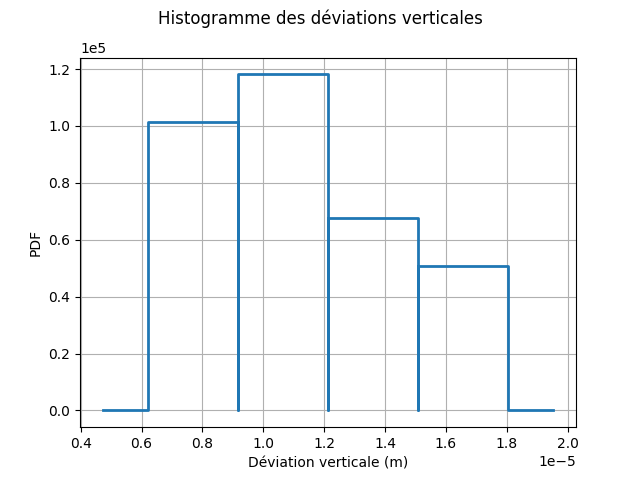

In [6]:
histo = ot.HistogramFactory().build(Y_train).drawPDF()
histo.setXTitle("Déviation verticale (m)")
histo.setTitle("Histogramme des déviations verticales")
histo.setLegends([""])
histo

### Création du méta-modèle

Pour créer le krigeage, on choisit une tendance constante avec la classe `ConstantBasisFactory`. Puis on utilise un modèle de covariance de type exponentielle carrée. Enfin, on utilise la classe `KrigingAlgorithm` pour créer le krigeage en utilisant la base d'apprentissage, le modèle de covariance et la tendance.

In [7]:
dimension = myDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(X_train.getMax())  # Trick A
fitter = otexp.GaussianProcessFitter(X_train, Y_train, covarianceModel, basis)
x_range = X_train.getMax() - X_train.getMin()  # Trick B, v2
scale_max_factor = 5.0  # Must be > 1, tune this to match your problem
scale_min_factor = 0.1  # Must be < 1, tune this to match your problem
maximum_scale_bounds = scale_max_factor * x_range
minimum_scale_bounds = scale_min_factor * x_range
scaleOptimizationBounds = ot.Interval(minimum_scale_bounds, maximum_scale_bounds)
fitter.setOptimizationBounds(scaleOptimizationBounds)
scaleOptimizationBounds

class=Interval name=Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[1.70306e+06,3288.25,0.0081952,9.78565] upper bound=class=Point name=Unnamed dimension=4 values=[8.51532e+07,164413,0.40976,489.283] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]

In [8]:
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()


In [9]:
gpr_result = gpr.getResult()
krigeageMM = gpr_result.getMetaModel()

La méthode `run` a évalué les paramètres du modèle par la méthode du maximum de vraisemblance. 

On peut alors afficher la tendance constante du modèle.

In [10]:
gpr_result.getTrendCoefficients()

class=Point name=Unnamed dimension=1 values=[2.95717e-05]

On peut également afficher les paramètres du modèle de covariance, estimés par la méthode du maximum de vraisemblance.

In [11]:
gpr_result.getCovarianceModel()

class=SquaredExponential scale=class=Point name=Unnamed dimension=4 values=[5.32949e+07,77044.8,0.40976,489.283] amplitude=class=Point name=Unnamed dimension=1 values=[1.94347e-05]

On observe que les longueurs de corrélation optimisées $\theta_E^\star$, $\theta_F^\star$ et $\theta_I^\star$ sont strictement à l'intérieur du domaine. En revanche, la longueur de corrélation optimale pour le paramètre $L$ est $\theta_L^\star = 0.40976$, c'est à dire égale à la borne maximale utilisée par l'algorithme d'optimisation. Cette longueur de corrélation optimale est supérieure à l'étendue du domaine de définition de la variable $L$, égale à $2.6 - 2.5 = 0.1$. Une grande longueur de corrélation signifie que deux points $\boldsymbol{x}_1=(E, F, L_1, I)^T$ et $\boldsymbol{x}_2=(E, F, L_2, I)^T$ tels que $L_1$ et $L_2$ sont très éloignés sont associées à des valeurs de $Y = g(\boldsymbol{x})$ très proches. Ce résultat est cohérent avec le fait que la fonction $g$ est peu sensible à la variable $L$, comme on peut le voir en réalisant l'analyse de sensibilité globale du modèle (son indices de Sobol' total est proche de zéro). En d'autres termes, la fonction $g$ est presque constante lorsque $L$ change (et que les autres paramètres sont maintenus constants). 

On souhaite ensuite valider le métamodèle de krigeage. Pour cela, on génère un échantillon de validation de taille 100 et on évalue la sortie du modèle sur cet échantillon.

In [12]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

Sur l'échantillon de validation, on évalue les sorties du méta-modèle.

In [13]:
Y_test_MM = krigeageMM(X_test)

La classe `MetaModelValidation` facilite le travail de validation d'un métamodèle. Pour la constuire, on lui donne les entrées de la base de validation, les sorties correspondantes et le métamodèle.

In [14]:
krigeageMMPredictions = krigeageMM(X_test)
val = ot.MetaModelValidation(Y_test, krigeageMMPredictions)

La méthode `computeR2Score` permet d'estimer le coefficient $Q_2$.

In [15]:
Q2 = val.computeR2Score()[0]
Q2

0.9945266796966972

Puisque le $Q_2$ est supérieur à 0.95, on peut dire que c'est un très bon méta-modèle.

Il est intéressant de dessiner l'histogramme des résidus : on peut le faire avec la classe `HistogramFactory` appliquée à l'échantillon des résidus `r`. 

On observe que les résidus négatifs sont presque aussi fréquents que les résidus positifs : c'est plutôt un signe positif pour la qualité du métamodèle. Dans notre cas, la déviation verticale est plutôt petite, de l'ordre de $10^{-5}$. Cela implique qu'il n'est pas si simple de voir si, en valeur absolue, les résidus sont plutôt petits, ou non : le graphique que nous dessinerons par la suite est plus fiable de ce point de vue.

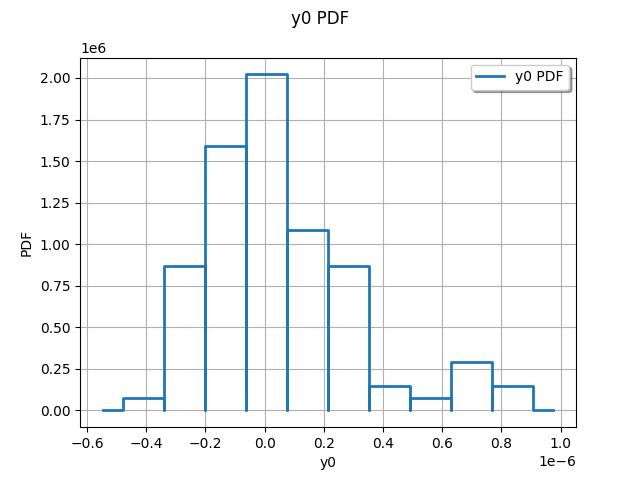

In [16]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

La méthode `drawValidation` permet de comparer les données observées et les prédictions du méta-modèle. 

On observe que les croix rouges sont à proximité de la première bissectrice : cela montre que le méta-modèle est plutôt de bonne qualité. Toutefois, pour les grandes déviations, les points rouges sont plus éloignées de la première bissectrice : le métamodèle est moins bon pour les grandes déviations.

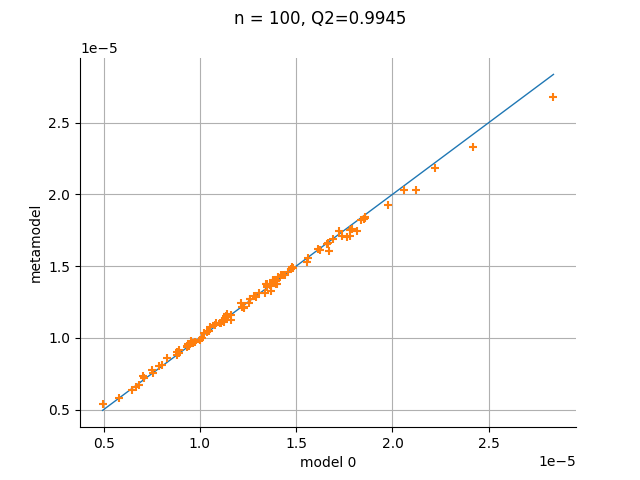

In [17]:
graph = val.drawValidation()
graph.setTitle("n = %d, Q2=%.4f" % (sampleSize_test, Q2))
graph

## Annexe : coefficient de prédictivité

Le facteur de prédictivité $Q_2$ est un coefficient qui mesure la qualité d'un méta-modèle. 
* C'est un nombre entre 0 et 1.
* Si Q2 est proche de 1, alors le métamodèle est excellent.
* Si Q2 est proche de 0, alors le métamodèle est une mauvaise approximation de la fonction.

En pratique, un $Q_2$ supérieur à 0.95 est qualifié de satisfaisant. 

On suppose que l'on dispose de $n$ entrées de validation $\boldsymbol{x}_i$ ainsi que des observations $y_i$ correspondantes. On note $M$ le méta-modèle. 
Soit $\bar{y}$ la moyenne des observations de validation :
$$
\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$
Le coefficient $Q_2$ est défini par l'équation :
$$
Q_2 = 1 - \frac{\sum_{i=1}^{n} (y_i - M(\boldsymbol{x}_i))^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}.
$$

## Exercices

### Exercice 1 : sensibilité à la taille de l'échantillon d'apprentissage

On s'interroge sur l'évolution de la qualité du métamodèle lorsque le nombre de points dans le plan d'expériences augmente. 

**Questions**
* Modifier le plan d'expériences utilisé pour apprendre le méta-modèle : utiliser `sampleSize_train = 100`. 
* Mettre à jour le métamodèle de krigeage. 
* Comment évolue le coefficient de prédictivité ?
* Pourquoi ?

### Exercice 2 : utilisation d'une tendance

Il y a trois classes qui permettent de créer des modèles de tendance.
* `ConstantBasisFactory` : tendance constante
* `LinearBasisFactory` : tendance linéaire
* `QuadraticBasisFactory` : tendance quadratique

**Questions**
* Mettre à jour la tendance du modèle et utiliser une tendance linéaire. 
* Quelle est la tendance estimée par la méthode du maximum de vraisemblance ?
* Quel est l'impact sur la qualité du méta-modèle ?

### Exercice 3 : nombre d'observations et nombre de paramètres

On souhaite vérifier que le nombre d'observations est suffisant pour estimer correctement les paramètres. 

* Calculer le nombre de paramètres estimés dans le krigeage. Pour cela, faire la somme du nombre de paramètres de la tendance et du noyau de covariance.
* Calculer le nombre d'observations dans le plan d'expériences. 
* Calculer le ratio entre le nombre d'observations et le nombre de paramètres. 
* La taille du plan d'expériences est-elle suffisante pour estimer les paramètres ?

### Exercice 4 : distribution des résidus

On souhaite valider la qualité du métamodèle. Nous avons vu comment récupérer les résidus avec la classe `getResidualSample` et tracer l'histogramme de ces résidus avec la classe `HistogramFactory`. Il s'avère que l'on peut récupérer directement la distribution des résidus avec 

**Questions**
* Utiliser la méthode `getResidualDistribution` pour obtenir la distribution des résidus.
* Utiliser la méthode `drawPDF` pour dessiner la distribution des résidus.
* Que conclure ?